In [1]:
from catboost import CatBoostRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
import pandas as pd
from time import time
import pprint
import joblib
import warnings
warnings.filterwarnings("ignore")

# Classifiers
from catboost import CatBoostClassifier

# Model selection
from sklearn.model_selection import StratifiedKFold

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn import metrics

# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper
from skopt.space import Real, Categorical, Integer
from time import time

import shap
import seaborn as sns

In [2]:
def addlogs(res, cols):
    """ Log transform feature list"""
    m = res.shape[1]
    for c in cols:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[c])).values)   
        res.columns.values[m] = c + '_log'
        m += 1
    return res

# Data

In [3]:
df = pd.read_csv('../data/features/feature_set_v2.csv')

In [4]:
len(df)

1316

In [5]:
df.price_type.value_counts()

venta    1173
renta     143
Name: price_type, dtype: int64

In [6]:
df.groupby('price_type').agg({'precio_m2_final':'describe'})

precio_m2_final                                            \
                     count          mean           std           min   
price_type                                                             
renta                143.0  40062.906870  12429.950208  22040.816327   
venta               1173.0  59590.340556  17247.248833  10271.739130   

                                                                     
                     25%           50%           75%            max  
price_type                                                           
renta       31664.427157  39183.673469  44607.142857   93061.224490  
venta       51123.595506  59916.666667  68881.500000  119696.969697

# Normalizar

In [7]:
df['num_comercios_norm'] = (df['num_comercios_imp']-df['num_comercios_imp'].min()) / (df['num_comercios_imp'].max()-df['num_comercios_imp'].min())
df['is_consultorio_norm'] = (df['is_consultorio_imp']-df['is_consultorio_imp'].min()) / (df['is_consultorio_imp'].max()-df['is_consultorio_imp'].min())
df['is_recreativo_norm'] = (df['is_recreativo_imp']-df['is_recreativo_imp'].min()) / (df['is_recreativo_imp'].max()-df['is_recreativo_imp'].min())
df['is_retail_norm'] = (df['is_retail_imp']-df['is_retail_imp'].min()) / (df['is_retail_imp'].max()-df['is_retail_imp'].min())
df['is_escuela_norm'] = (df['is_escuela_imp']-df['is_escuela_imp'].min()) / (df['is_escuela_imp'].max()-df['is_escuela_imp'].min())


# Features

In [8]:
df.columns

Index(['price_type', 'lat', 'lon', 'years', 'CVEGEO', 'new_id',
       'num_comercios_imp', 'is_consultorio_imp', 'is_recreativo_imp',
       'is_retail_imp', 'is_escuela_imp', 'Baños_imp', 'Recámaras_imp',
       'precio_m2_final', 'nearest_50_pct_price', 'nearest_75_pct_price',
       'nearest_25_pct_price', 'nearest_std_price', 'distance_parque',
       'distance_fuente', 'ageb_precio_m2_25_pct', 'ageb_precio_m2_50_pct',
       'ageb_precio_m2_75_pct', 'num_comercios_norm', 'is_consultorio_norm',
       'is_recreativo_norm', 'is_retail_norm', 'is_escuela_norm'],
      dtype='object')

In [9]:
var_y = ['precio_m2_final']
var_x = [
       #'num_comercios_norm', 'is_consultorio_norm', 'is_recreativo_norm',
       #'is_retail_norm', 'is_escuela_norm', 
       #'num_comercios_imp', 
        #'is_consultorio_imp', 
        'is_recreativo_imp',
        'is_retail_imp', 
       #'is_escuela_imp', 
        #'is_depto', 
    
      # 'nearest_50_pct_price', 
       'nearest_75_pct_price',
       'nearest_25_pct_price', 
       'ageb_precio_m2_25_pct',
     #  'ageb_precio_m2_50_pct', 
       'ageb_precio_m2_75_pct',
       'nearest_std_price',
    
        'distance_parque',
        'distance_fuente'
        ]
cat_x = [ 
            'price_type', 
      #  'CVEGEO',
]

In [10]:
len(var_x+cat_x)

10

In [11]:
var_x_log = [
    'is_recreativo_imp_log', 'is_retail_imp_log',
       'nearest_75_pct_price_log', 'nearest_25_pct_price_log',
       'ageb_precio_m2_25_pct_log', 'ageb_precio_m2_75_pct_log',
       'nearest_std_price_log', 'distance_parque_log', 'distance_fuente_log'
    
]

In [12]:
X = df[cat_x+var_x_log]
y = df[['SalePrice']]

KeyError: "['is_recreativo_imp_log', 'is_retail_imp_log', 'nearest_75_pct_price_log', 'nearest_25_pct_price_log', 'ageb_precio_m2_25_pct_log', 'ageb_precio_m2_75_pct_log', 'nearest_std_price_log', 'distance_parque_log', 'distance_fuente_log'] not in index"

In [13]:
X = df[var_x+cat_x]
y = df[var_y]

In [14]:
X.isna().sum()

is_recreativo_imp        0
is_retail_imp            0
nearest_75_pct_price     0
nearest_25_pct_price     0
ageb_precio_m2_25_pct    0
ageb_precio_m2_75_pct    0
nearest_std_price        0
distance_parque          0
distance_fuente          0
price_type               0
dtype: int64

In [15]:
X = X.fillna(0)

# Train / Test

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Model

In [17]:
import catboost as cb

In [18]:
train_dataset = cb.Pool(X_train, y_train, cat_features=cat_x) 
test_dataset = cb.Pool(X_test, y_test, cat_features=cat_x)

In [19]:
reg = cb.CatBoostRegressor(
                         loss_function='RMSE',
                         cat_features=cat_x,
                         verbose = False
                        )

In [20]:
# Defining your search space
grid = {'iterations': [100, 150, 200],
        'learning_rate': [.01, 0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}

In [21]:
# Setting up BayesSearchCV
reg.grid_search(grid, train_dataset)


bestTest = 26550.21508
bestIteration = 99

0:	loss: 26550.2150756	best: 26550.2150756 (0)	total: 129ms	remaining: 18.4s

bestTest = 15384.28818
bestIteration = 99

1:	loss: 15384.2881808	best: 15384.2881808 (1)	total: 162ms	remaining: 11.5s

bestTest = 14189.17019
bestIteration = 98

2:	loss: 14189.1701918	best: 14189.1701918 (2)	total: 195ms	remaining: 9.14s

bestTest = 26576.44547
bestIteration = 99

3:	loss: 26576.4454663	best: 14189.1701918 (2)	total: 231ms	remaining: 8.08s

bestTest = 15389.64674
bestIteration = 99

4:	loss: 15389.6467430	best: 14189.1701918 (2)	total: 263ms	remaining: 7.31s

bestTest = 14173.33411
bestIteration = 97

5:	loss: 14173.3341090	best: 14173.3341090 (5)	total: 294ms	remaining: 6.76s

bestTest = 26607.34539
bestIteration = 99

6:	loss: 26607.3453917	best: 14173.3341090 (5)	total: 326ms	remaining: 6.38s

bestTest = 15400.94904
bestIteration = 99

7:	loss: 15400.9490402	best: 14173.3341090 (5)	total: 368ms	remaining: 6.25s

bestTest = 14231.4552
bestItera

{'params': {'depth': 6,
  'iterations': 200,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [22]:
pred = reg.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 12763.43
R2: 0.49


In [23]:
results = X_test.copy()
results['preds'] = pred
results['y'] = y_test['precio_m2_final'].tolist()

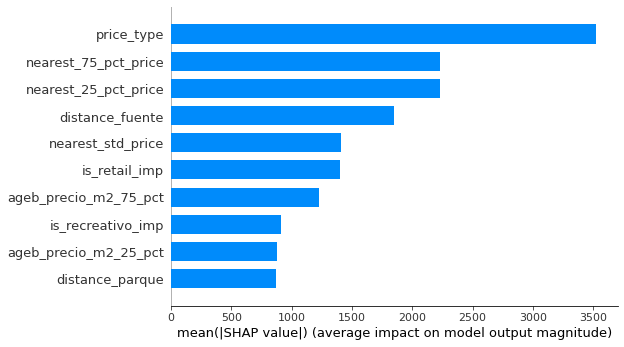

In [24]:
shap_values = shap.TreeExplainer(reg).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

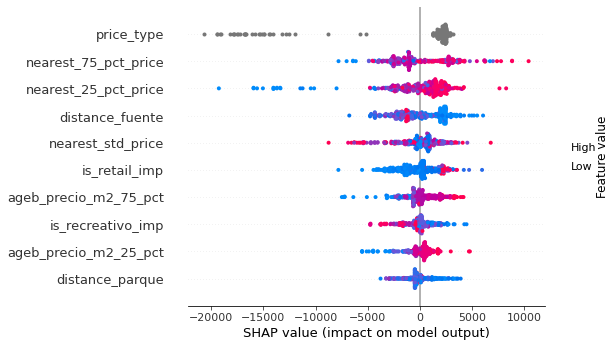

In [25]:
shap.summary_plot(shap_values, X_test)

In [26]:
results['obs'] = 1
results['obs'] = results['obs'].cumsum()

In [27]:
results.head(1)

,is_recreativo_imp,is_retail_imp,nearest_75_pct_price,nearest_25_pct_price,ageb_precio_m2_25_pct,ageb_precio_m2_75_pct,nearest_std_price,distance_parque,distance_fuente,price_type,preds,y,obs
198,59.0,71.0,67854.938272,60395.246479,51428.571429,68852.459016,6778.306165,1075.428479,190.747273,venta,61209.782833,63750.0,1


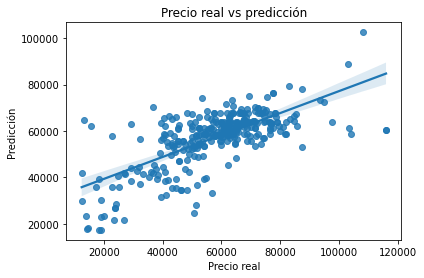

In [28]:
ax = sns.regplot(x='y', y='preds', data=results)
plt.xlabel('Precio real')
plt.ylabel('Predicción')
plt.title('Precio real vs predicción')
plt.show()

<AxesSubplot:xlabel='obs', ylabel='y'>

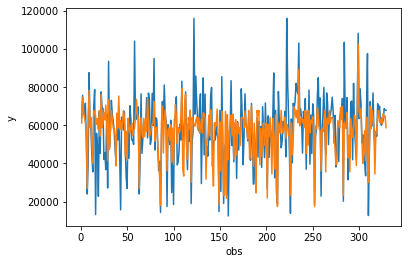

In [29]:
sns.lineplot(data=results, x="obs", y="y")
sns.lineplot(data=results, x="obs", y="preds")

In [30]:
results['abs_error'] = abs(results.y-results.preds)
results['error'] = results.y-results.preds

In [31]:
results.head(1)

,is_recreativo_imp,is_retail_imp,nearest_75_pct_price,nearest_25_pct_price,ageb_precio_m2_25_pct,ageb_precio_m2_75_pct,nearest_std_price,distance_parque,distance_fuente,price_type,preds,y,obs,abs_error,error
198,59.0,71.0,67854.938272,60395.246479,51428.571429,68852.459016,6778.306165,1075.428479,190.747273,venta,61209.782833,63750.0,1,2540.217167,2540.217167


In [34]:
results.head(1)

,is_recreativo_imp,is_retail_imp,nearest_75_pct_price,nearest_25_pct_price,ageb_precio_m2_25_pct,ageb_precio_m2_75_pct,nearest_std_price,distance_parque,distance_fuente,price_type,preds,y,obs,abs_error,error
198,59.0,71.0,67854.938272,60395.246479,51428.571429,68852.459016,6778.306165,1075.428479,190.747273,venta,61209.782833,63750.0,1,2540.217167,2540.217167


In [35]:
results.groupby('price_type').agg({'y':'describe'})

y                                                          \
            count          mean           std           min           25%   
price_type                                                                  
renta        34.0  42740.608415  10694.574964  24761.904762  36243.697479   
venta       295.0  59056.463385  17708.832743  12500.000000  50000.000000   

                                                       
                     50%           75%            max  
price_type                                             
renta       40979.591837  50361.394558   65306.122449  
venta       60869.565217  68852.459016  116000.000000

In [36]:
8085.841637/40979.591837

0.19731386464663095

In [37]:
5947.295833/60869.565217

0.09770557439991381

In [32]:
results.groupby('price_type').agg({'abs_error':'describe'})

abs_error                                                    \
               count         mean          std        min          25%   
price_type                                                               
renta           34.0  8852.182694  5518.998394  37.838514  4722.936699   
venta          295.0  9101.346462  9311.354962  85.706951  2838.003667   

                                                     
                    50%           75%           max  
price_type                                           
renta       8085.841637  13890.577151  23129.538666  
venta       5947.295833  12874.194717  55391.479285

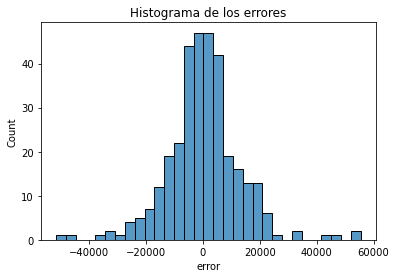

In [33]:
ax = sns.histplot(results.error)
plt.title('Histograma de los errores')
plt.show()

In [678]:
from catboost import Pool

In [680]:
pool = Pool(X_train, y_train,
            feature_names=var_x+cat_x, cat_features=cat_x)

In [681]:
# Export as dot file
reg.plot_tree(tree_idx=0, pool=pool).render('regression_tree')

'regression_tree.pdf'

In [683]:
results.preds.describe()

count       329.000000
mean      57023.730507
std       12078.599856
min       17423.428259
25%       54133.266133
50%       59485.048733
75%       64021.548647
max      102518.098724
Name: preds, dtype: float64

In [684]:
results.y.describe()

count       329.000000
mean      57370.326397
std       17814.185439
min       12500.000000
25%       47000.011765
50%       59611.111111
75%       67857.142857
max      116000.000000
Name: y, dtype: float64

In [665]:
X_train_reg = X_train.drop(columns=['price_type'])
X_test_reg = X_test.drop(columns=['price_type'])

In [666]:
import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
import lightgbm as lgb

# Regresión

In [667]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 100000
}

In [668]:
gbm = lgb.LGBMRegressor(**hyper_params)

In [583]:
model = xgboost.XGBRegressor(n_estimators=300, max_depth=8, 
                             eta=0.1, subsample=0.7, colsample_bytree=0.8)

In [670]:
gbm.fit(X_train_reg, y_train,
        eval_set=[(X_test_reg, y_test)],
        eval_metric='l1',
        early_stopping_rounds=1000)

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] fe

LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              learning_rate=0.005, max_bin=512, max_depth=8,
              metric=['l1', 'l2'], num_iterations=100000, num_leaves=128,
              objective='regression', task='train', verbose=0)

In [671]:
pred = gbm.predict(X_test_reg)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 14138.84
R2: 0.37


In [672]:
results['other'] = pred

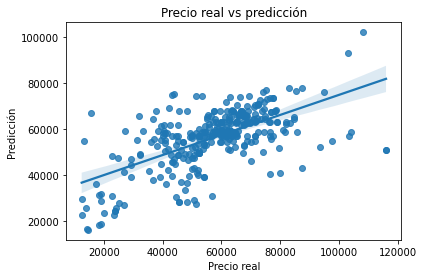

In [673]:
ax = sns.regplot(x='y', y='other', data=results)
plt.xlabel('Precio real')
plt.ylabel('Predicción')
plt.title('Precio real vs predicción')
plt.show()

In [674]:
results['final_pred'] = (results['preds']+results['other'])/2

In [675]:
rmse = (np.sqrt(mean_squared_error(y_test, results['final_pred'])))
r2 = r2_score(y_test, results['final_pred'])
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 13005.04
R2: 0.47
